# Detecting generated scientific papers

Competition [website here...](https://www.kaggle.com/competitions/detecting-generated-scientific-papers/overview)

### Description
This competition is a part of the shared task hosted within the third workshop on Scholarly Document Processing ([SDP 2022](https://sdproc.org/2022/)), being held in association with the 29th International Conference on Computational Linguistics ([COLING 2022](https://coling2022.org/)).

There are increasing reports that research papers can be written by computers, which presents a series of concerns (e.g., see [1]). In this challenge, we explore the state of the art in detecting automatically generated papers. We frame the detection problem as a binary classification task: given an excerpt of text, label it as either human-written or machine-generated. We provide a corpus of over 5000 excerpts from automatically written papers, based on the work by Cabanac et al. [2], as well as documents collected by Elsevier publishing and editorial teams. As a control set, we provide a 5x larger corpus of openly accessible human-written as well as generated papers from the same scientific domains of documents. We also encourage contributions that aim to extend this dataset with other computer-generated scientific papers, or papers that propose valid metrics to assess automatically generated papers against those written by humans.

### Acknowledgements
We thank Cyril Labbé, Basile Dubois-Binnaire, Guillaume Cabanac, and Alexander Magazinov for their input in the ideation phase of the task preparation.

### Links
[1] Holly Else. (2021). ["'Tortured phrases' give away fabricated research papers."](https://www.nature.com/articles/d41586-021-02134-0) Nature.

[2] Guillaume Cabanac, Cyril Labbé, and Alexander Magazinov. (2021). ["Tortured phrases: A dubious writing style emerging in science. Evidence of critical issues affecting established journals."](https://arxiv.org/abs/2107.06751)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, gc

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from transformers import TFBertModel
import transformers

from sklearn.metrics import f1_score, mean_squared_error

from sklearn.model_selection import StratifiedKFold

# Loading data

In [2]:
train = pd.read_csv("../input/detecting-generated-scientific-papers/fake_papers_train_part_public.csv")
test = pd.read_csv("../input/detecting-generated-scientific-papers/fake_papers_test_public.csv")

train.shape, test.shape

((5350, 3), (21403, 2))

In [3]:
train.head()

,id,text,fake
0,1,Modern two-dimensional imaging is of such qual...,0
1,2,Background: The optimal sequence of systemic p...,1
2,5,This chapter opens with a discussion of the ef...,1
3,10,The time scale of the ultra-short-term can str...,1
4,23,Electronic nose or machine olfaction are syste...,1


- Checking Missing Values

In [4]:
train.isna().sum().any(), test.isna().sum().any()

(False, False)

- Checking target distribution

In [5]:
train["fake"].value_counts()

1    3664
0    1686
Name: fake, dtype: int64

# Pre-processing Data

### Configuration

In [6]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
BATCH_SIZE = 16
MAX_LEN = 256

### Bert Encoder

In [7]:
def bert_encode(texts, tokenizer, max_len=MAX_LEN):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

### Loading bert tokenizer

In [8]:
bert_large = '../input/huggingface-bert-variants/bert-large-cased/bert-large-cased'
bert_base = '../input/huggingface-bert-variants/bert-base-cased/bert-base-cased'
distilbert_base = '../input/huggingface-bert-variants/distilbert-base-cased/distilbert-base-cased'
distilbert_base_squad = '../input/huggingface-bert-variants/distilbert-base-cased-distilled-squad/distilbert-base-cased-distilled-squad'

tokenizer = transformers.BertTokenizer.from_pretrained(bert_base)
#tokenizer.save_pretrained('.')

### Splitting Data

In [9]:
y = train.pop('fake')
y

0       0
1       1
2       1
3       1
4       1
       ..
5345    1
5346    1
5347    0
5348    1
5349    1
Name: fake, Length: 5350, dtype: int64

### Setup GPU

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2022-08-08 05:51:38.841659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 05:51:38.842766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 05:51:38.843459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 05:51:38.854844: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Modeling

In [11]:
def build_model(bert_model, max_len=MAX_LEN):    
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    sequence_output = bert_model.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(.1)(clf_output)
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
%%time
transformer_layer = (TFBertModel.from_pretrained(bert_base))
#model = build_model(transformer_layer, max_len=MAX_LEN)
#model.summary()

Some layers from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


CPU times: user 1.08 s, sys: 705 ms, total: 1.79 s
Wall time: 7.12 s


### Callback

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=3,
    #min_delta=0.001,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.75,
    patience=4, #min_lr=1357e-6
)

"""
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=350,
    #batch_size=512,
    epochs=12,
    callbacks=[early_stopping],
    #verbose=0

)
"""

'\nhistory = model.fit(\n    train_dataset,\n    validation_data=valid_dataset,\n    steps_per_epoch=350,\n    #batch_size=512,\n    epochs=12,\n    callbacks=[early_stopping],\n    #verbose=0\n\n)\n'

In [14]:
def plot_curve(history=pd.DataFrame()):
    history_df = pd.DataFrame(history.history)
    # Start the plot at epoch 0
    history_df.loc[0:, ['loss', 'val_loss']].plot()
    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

    print(("Best Validation Loss: {:0.4f}" +\
          "\nBest Validation Accuracy: {:0.4f}")\
          .format(history_df['val_loss'].min(), 
                  history_df['val_accuracy'].max()))

### Bert Encode test data

In [15]:
test_text = bert_encode(test.text.astype(str), tokenizer)

# Cross-Validation

**************  Fold 0  ************** 



2022-08-08 05:53:48.876214: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



 MSE : 0.029120451920350933 

Best Validation Loss: 0.1383
Best Validation Accuracy: 0.9686


**************  Fold 1  ************** 


 MSE : 0.006166558287057434 



**************  Fold 2  ************** 


 MSE : 1.7307575637486847e-10 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 3  ************** 


 MSE : 5.717404253043713e-10 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 4  ************** 


 MSE : 3.572984136907175e-11 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 5  ************** 


 MSE : 2.0872454729883223e-10 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 6  ************** 


 MSE : 3.3298720813463305e-05 

Best Validation Loss: 0.0004
Best Validation Accuracy: 1.0000


**************  Fold 7  ************** 


 MSE : 9.287314022398335e-11 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


******

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 12  ************** 


 MSE : 7.785693234544319e-13 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 13  ************** 


 MSE : 6.850156701830745e-13 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 14  ************** 


 MSE : 1.989724490733888e-12 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 15  ************** 


 MSE : 2.2785325428870574e-13 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 16  ************** 


 MSE : 8.789718165503105e-14 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 17  ************** 


 MSE : 2.2609143154803506e-14 

Best Validation Loss: 0.0000
Best Validation Accuracy: 1.0000


**************  Fold 18  ************** 


 MSE : 2.5413218396102584e-13 

Best Validation Loss: 0.0000
Be

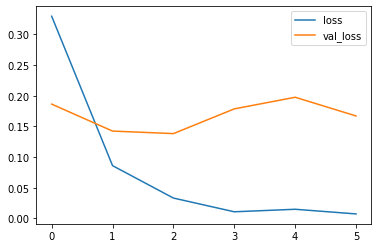

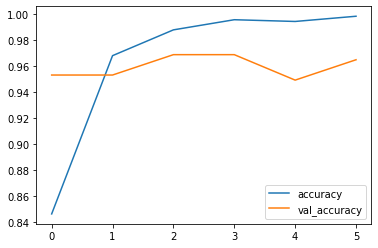

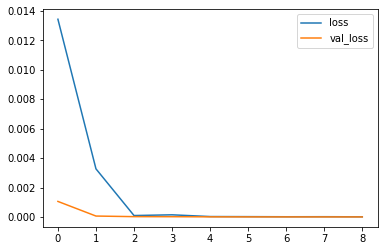

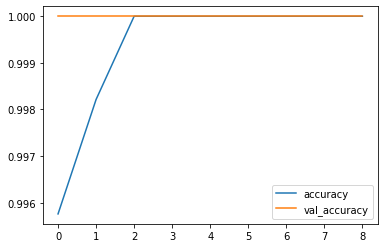

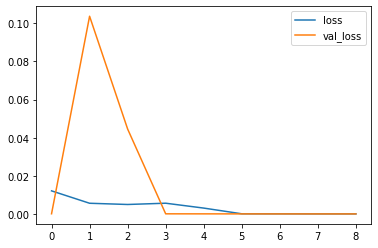

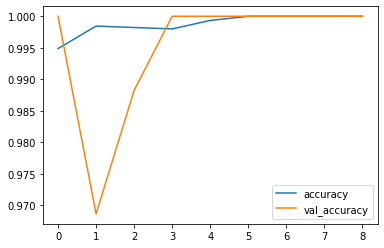

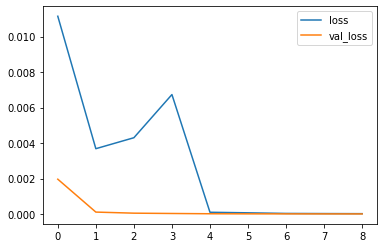

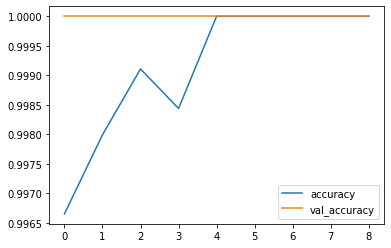

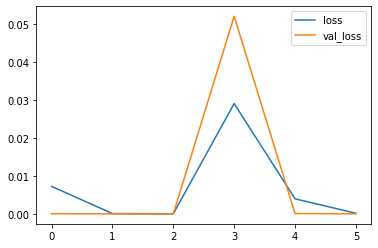

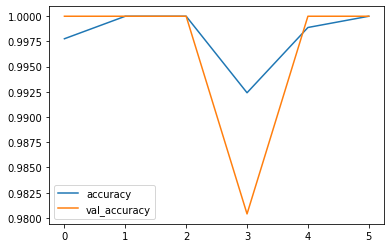

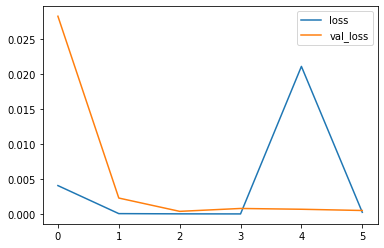

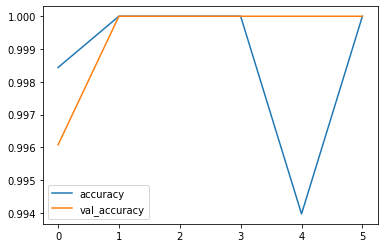

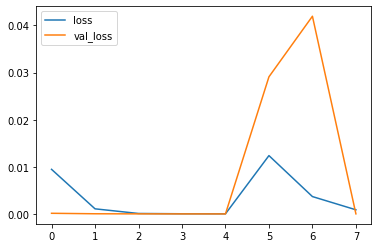

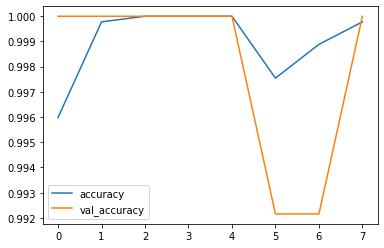

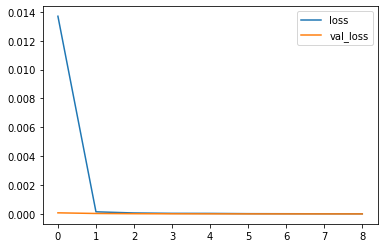

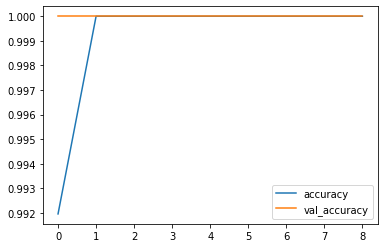

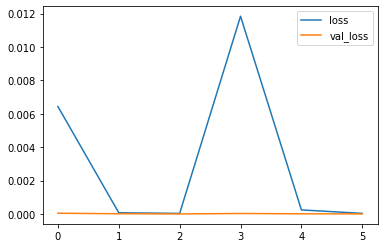

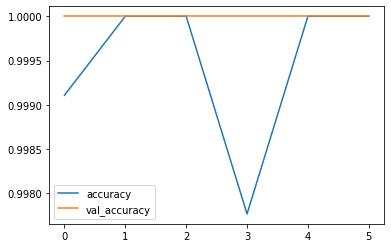

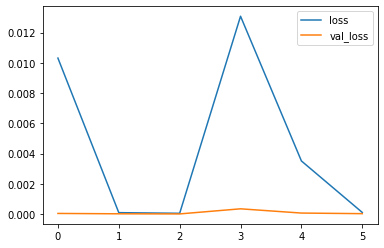

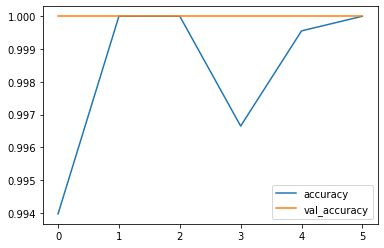

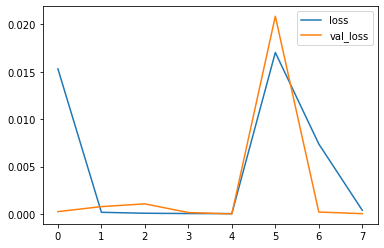

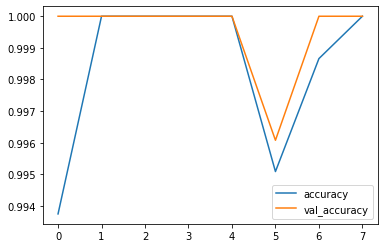

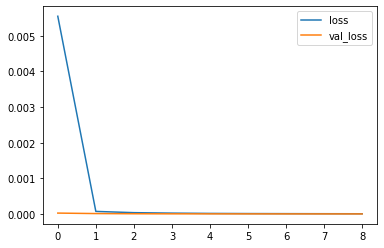

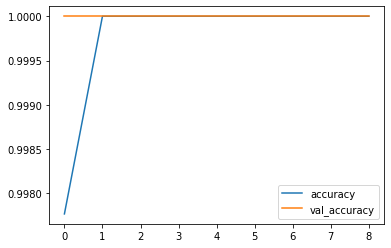

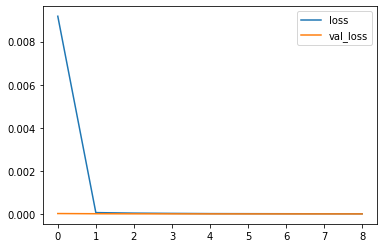

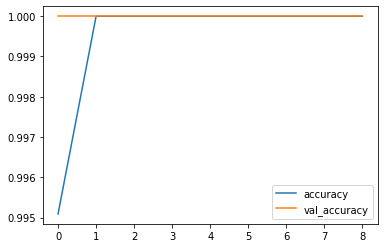

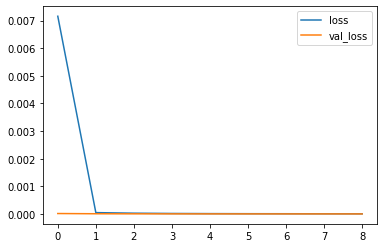

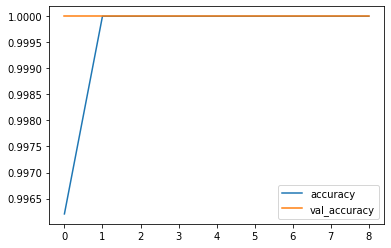

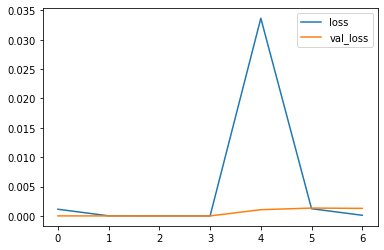

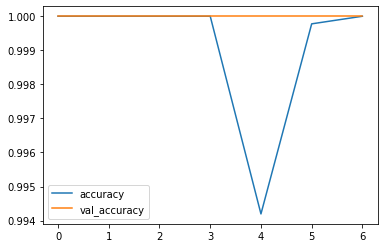

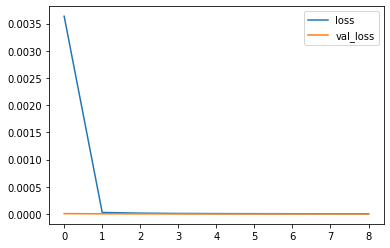

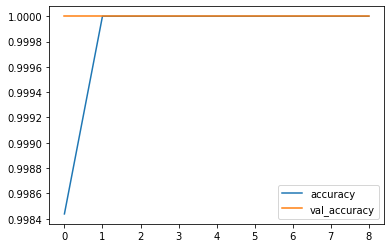

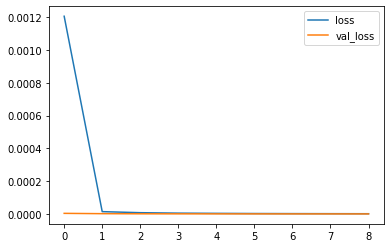

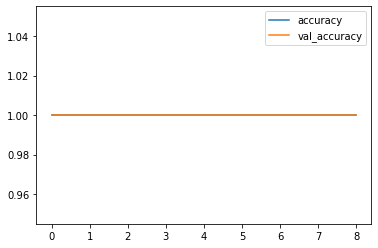

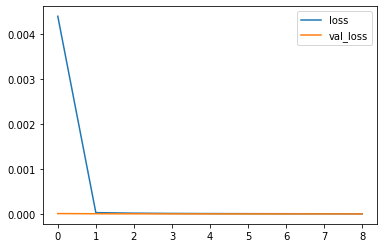

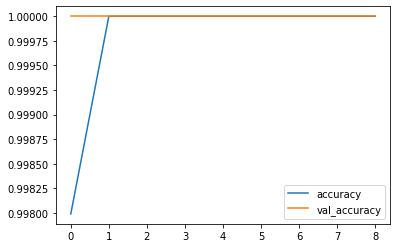

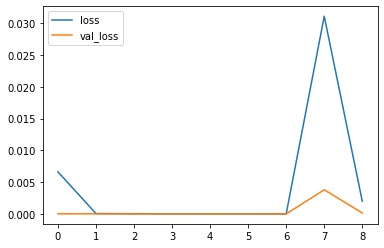

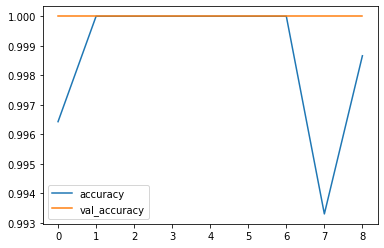

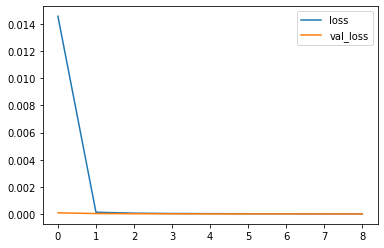

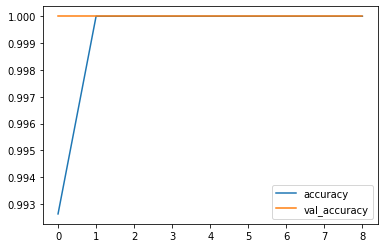

In [16]:
skf = StratifiedKFold(n_splits=21, random_state=1234, shuffle=True)

y_prediction = []
scores = []

for fold, (train_index, val_index) in enumerate(skf.split(train['text'], y)):
    print('*'*14, f" Fold {fold} ", '*'*14, '\n')

    # Splitting Data
    X_train, X_valid = train['text'][train_index], train['text'][val_index]
    y_train, y_valid = y[train_index], y[val_index]

    # Encode Data
    X_train = bert_encode(X_train.astype(str), tokenizer)
    X_valid = bert_encode(X_valid.astype(str), tokenizer)

    y_train = y_train.values
    y_valid = y_valid.values

    # Define train & valid dataset
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((X_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((X_valid, y_valid))
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )
    
    # Define Model
    model = build_model(transformer_layer, max_len=MAX_LEN)

    # Training
    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        steps_per_epoch=280,
        #batch_size=512,
        epochs=9,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Save Model Weights
    model.save_weights(f"dgsp_keras_model_{fold}.h5")
    #model.save(f'dgsp_keras_model_fold{fold}.v1')
    
    # Make X_val prediction
    y_pred = model.predict(X_valid)
    
    # Evaluate Model
    mse = mean_squared_error(y_valid, y_pred)
    scores.append(mse)
    print("\n MSE :", mse, '\n')
    
    # Test prediction
    if fold == 0:
        y_prediction.append(model.predict(test_text, verbose=0) )
        plot_curve(history)
        
    elif fold != 0 and mse <= 0.001:
        y_prediction.append(model.predict(test_text, verbose=0) )
        plot_curve(history)
        
    print("\n")

    # Free the memory
    del X_train, X_valid, y_train, y_valid, train_dataset, valid_dataset, history, y_pred, mse
    gc.collect()

In [17]:
print("Mean Squared Error : ", np.array(scores).mean(axis=0) )

Mean Squared Error :  0.001682034629923706


In [18]:
preds = np.array(y_prediction).mean(axis=0)
len(preds), test.shape[0]

(21403, 21403)

# Submission

- Saving with Threshold >= 0.5

In [19]:
sub = pd.read_csv('../input/detecting-generated-scientific-papers/sample_submission.csv')
sub['fake'] = (preds >= 0.5).astype(int)

sub.to_csv("submission.csv", index=False)
sub['fake'].value_counts()

1    14745
0     6658
Name: fake, dtype: int64

- Saving With Threshold  0.45 to 0.15

In [20]:
Thresholds = [0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4, 0.39, 0.38, 0.37]

for tresh in Thresholds:
    sub['fake'] = (preds >= tresh).astype(int)
    sub.to_csv(f"submission_trsh_{tresh}.csv", index=False)
    print("*** Threshold ", tresh, "*** \n", sub['fake'].value_counts(), "\n")

*** Threshold  0.49 *** 
 1    14746
0     6657
Name: fake, dtype: int64 

*** Threshold  0.48 *** 
 1    14756
0     6647
Name: fake, dtype: int64 

*** Threshold  0.47 *** 
 1    14760
0     6643
Name: fake, dtype: int64 

*** Threshold  0.46 *** 
 1    14768
0     6635
Name: fake, dtype: int64 

*** Threshold  0.45 *** 
 1    14773
0     6630
Name: fake, dtype: int64 

*** Threshold  0.44 *** 
 1    14778
0     6625
Name: fake, dtype: int64 

*** Threshold  0.43 *** 
 1    14779
0     6624
Name: fake, dtype: int64 

*** Threshold  0.42 *** 
 1    14785
0     6618
Name: fake, dtype: int64 

*** Threshold  0.41 *** 
 1    14795
0     6608
Name: fake, dtype: int64 

*** Threshold  0.4 *** 
 1    14804
0     6599
Name: fake, dtype: int64 

*** Threshold  0.39 *** 
 1    14809
0     6594
Name: fake, dtype: int64 

*** Threshold  0.38 *** 
 1    14819
0     6584
Name: fake, dtype: int64 

*** Threshold  0.37 *** 
 1    14825
0     6578
Name: fake, dtype: int64 

